In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('sample.csv')
df.head()

,author_ID,post,political_leaning
0,t2_kj8twzq5,dog (pic on my profile). Longer hair but other...,center
1,t2_1404zt,a skyscraper is probably gonna be mostly concr...,center
2,t2_4erzxbrz,intentionally wash your ass are Poseidon's fre...,center
3,t2_ccx3o6,you will struggle. Still Jungle is a very simi...,center
4,t2_b19hyjws,kitlesini sevmezdim ama kral adammış Genj adam...,center


In [3]:
# Load data
df = pd.read_csv('sample.csv')

# Text Preprocessing
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
    return ' '.join(lemmas)

df['clean_post'] = df['post'].apply(preprocess)
df['nr_of_words'] = df['clean_post'].apply(lambda x: len(x.split()))
df['nr_of_characters'] = df['clean_post'].apply(len)

# Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['political_leaning'])  # 0, 1, 2 for left, center, right

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2

# Vectorize text data
tfidf = TfidfVectorizer(max_features=1000)  # Adjust based on corpus size

# Combine with numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'clean_post'),
        ('num', 'passthrough', ['nr_of_words', 'nr_of_characters'])
    ]
)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[['clean_post', 'nr_of_words', 'nr_of_characters']], 
                                                    df['label'], test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=1000),
                                                  'clean_post'),
                                                 ('num', 'passthrough',
                                                  ['nr_of_words',
                                                   'nr_of_characters'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [8]:
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)


In [12]:
shap_values = explainer(X_test_transformed)

100%|===================| 22123/22128 [44:45<00:00]        

center


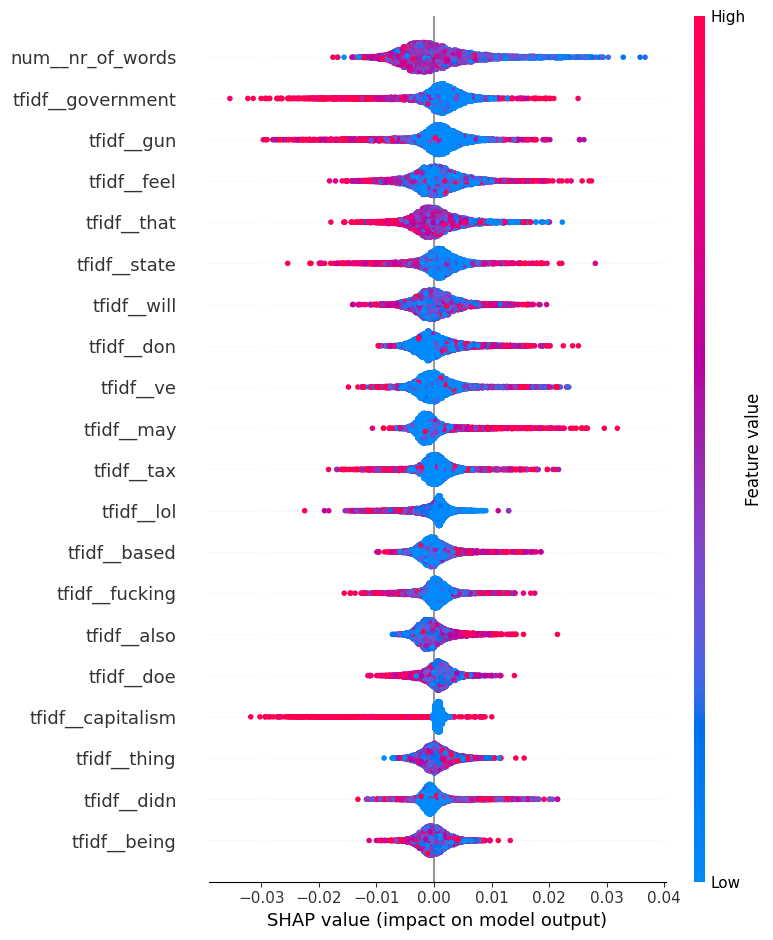

left


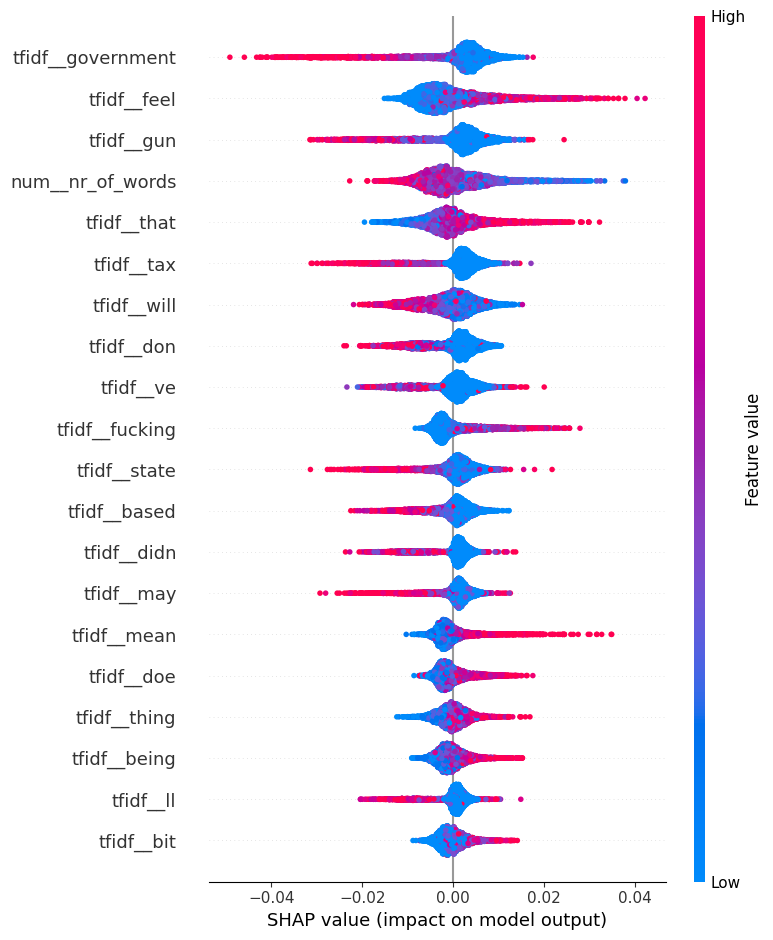

right


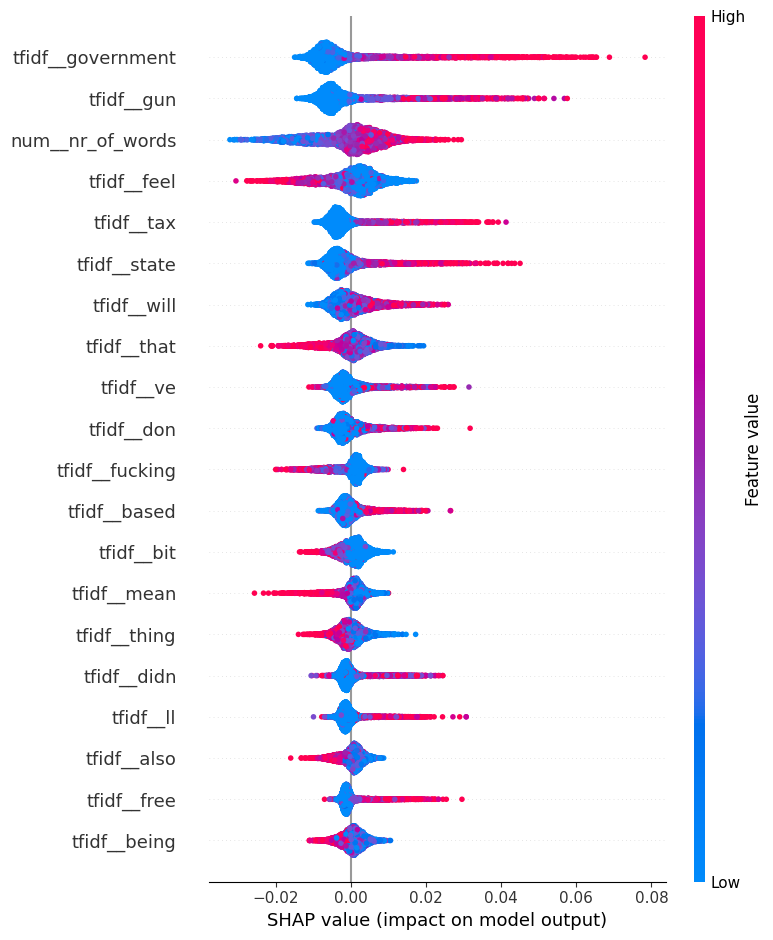

In [ ]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
for class_idx, class_name in enumerate(le.classes_):
    print(class_name)
    shap.summary_plot(shap_values[..., class_idx], X_test_transformed, 
                      feature_names=feature_names, 
                      title=f"SHAP Summary for Class: {class_name}")


In [20]:
# Aggregate SHAP values by feature
for class_idx, class_name in enumerate(le.classes_):
    print(f"\nTop features for class: {class_name}")
    shap_values_class = shap_values[..., class_idx]
    mean_importance = np.abs(shap_values_class.values).mean(axis=0)
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    important_features = sorted(zip(feature_names, mean_importance), key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in important_features:
        print(f"{feature}: {importance}")



Top features for class: center
num__nr_of_words: 0.004474493301128853
tfidf__government: 0.0036034026717993903
tfidf__gun: 0.0035330640501926333
tfidf__feel: 0.0032343087345802013
tfidf__that: 0.0029866418823859416
tfidf__state: 0.0027182715287726975
tfidf__will: 0.0027178642254913755
tfidf__don: 0.00263348255552835
tfidf__ve: 0.002567393171570566
tfidf__may: 0.0023992116427988958

Top features for class: left
tfidf__government: 0.006267984121743579
tfidf__feel: 0.0059158536399943834
tfidf__gun: 0.005270971566832133
num__nr_of_words: 0.005175630744616047
tfidf__that: 0.004572328889723212
tfidf__tax: 0.004410245649931043
tfidf__will: 0.004397396657239022
tfidf__don: 0.00414580034799198
tfidf__ve: 0.003659756493938371
tfidf__fucking: 0.003658291405588746

Top features for class: right
tfidf__government: 0.008791709340530451
tfidf__gun: 0.007397878208890244
num__nr_of_words: 0.006695533450124219
tfidf__feel: 0.005351688205927534
tfidf__tax: 0.004892391245442247
tfidf__state: 0.0047115879

In [23]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)


Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      2435
           1       0.79      0.74      0.76      2495
           2       0.75      0.75      0.75      2446

    accuracy                           0.73      7376
   macro avg       0.74      0.73      0.74      7376
weighted avg       0.74      0.73      0.74      7376

Confusion Matrix:
[[1736  308  391]
 [ 438 1842  215]
 [ 412  193 1841]]


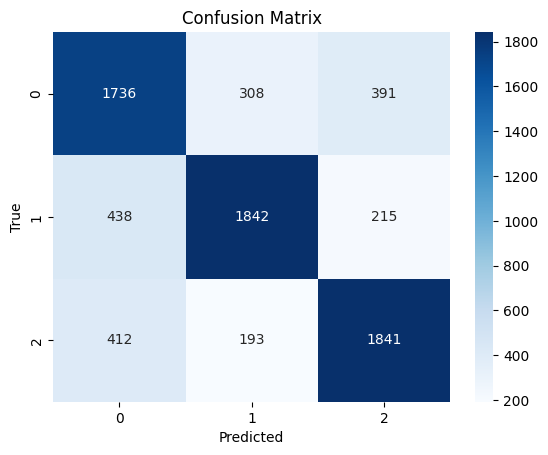

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
